<div style="display:block" direction=rtl align=right><br><br>
    <div  style="width:100%;margin:100;display:block"  display=block align=center>
        <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
        <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
        <span><br><font size=5>University of Tehran , school of ECE</font></span>
        <span><br><font size=3>Deep Generative Models Course</font></span>
        <span><br><font size=3>Fall 2023</font></span>
    </div><br><br><br>
    <div style="display:block" align=left display=block>
        <font size=3>Homework 2 - Part 2</font><br>
        <hr />
        <font size=3>TA: <a href="mailto:p.zilouchian@ut.ac.ir">Parham Zilouchian</a><br></font><br>
        <font size=3>TA: <a href="mailto:alirezaghafouri@ut.ac.ir">Alireza Ghafouri</a><br></font><br>
        
    </div>
</div>

# Working with GANs using PyTorch

This notebook is a homework assignment for the Deep Generative Models course at the University of Tehran. The goal of this assignment is to get familiar with the concept of Generative Adversarial Networks (GANs) and how to implement it with PyTorch. We will use the MNIST dataset for this assignment.

---


**Requisites**

*   Python 3.x
*   Jupyter
*   PyTorch >= 1.8
*   NumPy
*   Matplotlib
---

In [1]:
!free -m
!df -h
!nvidia-smi

               total        used        free      shared  buff/cache   available
Mem:           12982         843        9644           1        2494       11863
Swap:              0           0           0
Filesystem      Size  Used Avail Use% Mounted on
overlay          79G   27G   52G  35% /
tmpfs            64M     0   64M   0% /dev
shm             5.7G     0  5.7G   0% /dev/shm
/dev/root       2.0G  1.1G  885M  55% /usr/sbin/docker-init
tmpfs           6.4G  256K  6.4G   1% /var/colab
/dev/sda1        50G   30G   21G  59% /opt/bin/.nvidia
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
Sun Dec 10 08:43:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persisten

## **Import Libraries:**

Import your required libraries!

In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision

import argparse
import numpy as np
import os
import torch
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torchvision.utils import save_image
from tqdm import tqdm
import torchvision.utils as vutils

from torch import autograd, nn, optim
from torch.nn import functional as F

import argparse
from pprint import pprint
from torchvision import datasets, transforms

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
torch.manual_seed(1)

## **Downloading the dataset:**

We will use the MNIST dataset for this assignment. The dataset is already available in PyTorch, so we just need to download it.

In [4]:
preprocess = transforms.ToTensor()
train_loader = torch.utils.data.DataLoader(
            datasets.MNIST(root='./data', train=True, download=True, transform=preprocess),
            batch_size=128,
            shuffle=True
        )
test_loader = torch.utils.data.DataLoader(
            datasets.MNIST(root='./data', train=False, download=True, transform=preprocess),
            batch_size=128,
            shuffle=True
        )

# Create pre-processed training and test sets
X_train = train_loader.dataset.data.to(device).reshape(-1, 784).float() / 255
y_train = train_loader.dataset.data.to(device)
X_test = test_loader.dataset.data.to(device).reshape(-1, 784).float() / 255
y_test = test_loader.dataset.data.to(device)

print('Train dataset shape: ', X_train.data.shape)
print('Test dataset shape: ', y_train.data.shape)

100%|██████████| 9912422/9912422 [00:00<00:00, 257525635.95it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 42955919.80it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 86499460.89it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21073593.77it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Train dataset shape:  torch.Size([60000, 784])
Test dataset shape:  torch.Size([60000, 28, 28])


In [5]:
class Reshape(torch.nn.Module):
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
    def forward(self, x):
        return x.reshape(x.size(0), *self.shape)


class ReLU(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.maximum(x, torch.zeros_like(x))

## **Define Generator:**

We will use a simple 5-layer convolutional neural network for this assignment. The network is defined in the `Net` class below. The network is composed of 3 convolutional layers and 2 fully connected layers.

In [6]:
class Generator(torch.nn.Module):
    def __init__(self, z_dim=64, num_channels=1):
        super().__init__()
        self.z_dim = z_dim

        # Instantiate the Reshape module with the desired shape
        # self.reshape_module = Reshape(64,7,7)


        self.gen = nn.Sequential(
            # input is Z, going into a convolution
            # state size. ``128 x 64 ``
            nn.Linear(self.z_dim, 512),
            nn.BatchNorm1d(512),
            ReLU(),
            # state size. ``128 x 512 ``

            nn.Linear(512, 28*28*4),
            nn.BatchNorm1d(28*28*4),
            ReLU(),
            # state size. ``128 x 28*28*4 ``

            Reshape(64,7,7),
            # state size. ``128 x 64 x 7 x 7``

            nn.PixelShuffle(2),
            # state size. ``128 x 16 x 14 x 14``

            nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            ReLU(),
            # state size. ``128 x 32 x 14 x 14``


            nn.PixelShuffle(2),
            # state size. ``128 x 8 x 28 x 28``

            nn.Conv2d(8, 1, stride=1, kernel_size=3, padding=1, bias=False),
            # state size. ``128 x 1 x 28 x 28``
        )


    def forward(self, z):

      return self.gen(z)


## **Define Discriminator:**

We will use a simple 5-layer convolutional neural network for this assignment. The network is defined in the `Net` class below. The network is composed of 3 convolutional layers and 2 fully connected layers.

In [7]:
class Discriminator(torch.nn.Module):
    def __init__(self, num_channels=1):
        super().__init__()

        ############################# TODO #############################
        # Complete this part according to the introduced discriminator table on the provided manuscript!
        # YOUR CODE STARTS HERE

        self.disc = nn.Sequential(
            # input is Z, going into a convolution
            # self.reshape_module3,
            # state size. ``128 x 1 x 28 x 28``
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1, bias=False),
            ReLU(),
            # state size. ``128 x 32 x 14 x 14``
            nn.Conv2d(32, 64, kernel_size=4,stride=2, padding=1, bias=False),
            ReLU(),
            # state size. ``128 x 64 x 7 x 7``
            Reshape(64*7*7),
            # state size. ``128 x 64*7*7``
            nn.Linear(64*7*7,512),
            ReLU(),
            # state size. ``128 x 512``
            nn.Linear(512,1)
            # state size. ``128 x 1``

        )


    def forward(self, x):
      return torch.sigmoid(self.disc(x))
      # return self.disc(x)


      # layer_sizes = []
      # for layer in self.disc:
      #     x = layer(x)
      #     layer_sizes.append(x.size())
      #     print(f"Layer: {layer.__class__.__name__}, Output Size: {x.size()}")
      # return torch.sigmoid(x)

## **Define Your GAN:**

In [8]:
class GAN(nn.Module):
    def __init__(self, z_dim=2):
        super().__init__()
        self.z_dim = z_dim
        self.g = Generator(z_dim=z_dim)
        self.d = Discriminator()   # note that discriminator outputs logits

    def loss_nonsaturating(self, x_real, disc, device):
        '''
        Input Arguments:

        - x_real (torch.Tensor): training data samples (64, 1, 28, 28)
        - device (torch.device): 'cpu' by default

        Returns:
        - d_loss (torch.Tensor): nonsaturating discriminator loss
        - g_loss (torch.Tensor): nonsaturating generator loss
        '''

        ############################# TODO #############################
        # YOUR CODE STARTS HERE

        g_loss = None
        d_loss = None

        # generate fake images
        z = torch.randn(x_real.size(0),self.z_dim).to(device)
        x_fake = self.g(z)

        # discriminator logits for fake images
        d_fake = self.d(x_fake.to(device))


        if disc == 1:

          # discriminator logits for real images
          d_real = self.d(x_real.to(device))

          # non-saturating loss for discriminator
          real_loss = -torch.log(d_real+1e-8)
          fake_loss = -torch.log(1-d_fake+1e-8)
          d_loss = torch.sum(torch.mean(real_loss+fake_loss))

        else:
          # non-saturating loss for generator
          g_loss = -torch.mean(torch.log(d_fake+1e-8))

        # YOUR CODE ENDS HERE

        return d_loss, g_loss




## **Training Process:**

In [9]:

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

class Trainer:
    def __init__(self,
                 model,
                 optimizers,
                 device="cuda",
                 iter_max=1000,
                 iter_save=1000,
                 num_latents=64,
                 out_dir='/content/drive/MyDrive/MSC/Fall2023/DGM/HW2_part2/Q1_GAN/results'
            ):
        self.model = model
        self.optimizers = optimizers
        self.device = device
        self.iter_save = iter_save
        self.iter_max = iter_max
        self.out_dir = out_dir
        self.num_latents = num_latents


        # fix visualization latents
        self.z_test = torch.randn(100, self.num_latents).to(device)


    def build_input(self, x, y):
        x_real = x.to(self.device)
        y_real = y.to(self.device)
        return x_real, y_real

    def viz(self, global_step=1):
        with torch.no_grad():
            generator = self.model.g
            generator.eval()
            ############
            fake = ((generator(self.z_test) + 1) / 2.) #.detach().cpu()
            ###############
            generator.train()
        torchvision.utils.save_image(fake, '%s/fake_%04d.png' % (self.out_dir, global_step), nrow=10, padding=2, normalize=True)
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True, nrow=10))


    def checkpoint_and_log(self, global_step, loss, summaries):
        if global_step % self.iter_save == 0:
            with torch.no_grad():
                self.viz(global_step)
                torch.save((self.model.g, self.model.d), '%s/model_%04d.pt' % (self.out_dir, global_step))


    def gan_step(self, x_real, y_real, global_step):
        assert len(self.optimizers) == 2


        ############################# TODO #############################
        # Here you should calculate the loss for both the generator and discriminator parts!
        # After that, you have to apply this calculated loss to both the networks and update their weights respectively.
        # Here you have to use the "checkpoint_and_log" function in order to visualize and make checkpoint from your model!

        # YOUR CODE STARTS HERE
        # Get device
        device = self.device

        # Train discriminator
        self.optimizers[1].zero_grad()
        d_loss, _ = self.model.loss_nonsaturating(x_real, 1, device=device)


        d_loss.backward()
        self.optimizers[1].step()


        # Train generator
        self.optimizers[0].zero_grad()
        _, g_loss = self.model.loss_nonsaturating(x_real, 0, device=device)
        g_loss.backward()
        self.optimizers[0].step()

        # Checkpoint
        global_step += 1
        self.checkpoint_and_log(global_step, d_loss, g_loss)

        # return d_loss.item(), g_loss.item()
        # YOUR CODE ENDS HERE

        return d_loss, g_loss



    def train(self, train_loader, reinit=False):
        global_step = 0
        with tqdm(total=int(self.iter_max)) as pbar:
            ############################# TODO #############################
            # Here is your training loop!
            # YOUR CODE STARTS HERE
            # torch.autograd.set_detect_anomaly(True)

            while global_step < self.iter_max:

              # Get batch
              train_iter = iter(train_loader)
              x_real, y_real = next(train_iter)

              # Train step
              d_loss, g_loss = self.gan_step(x_real, y_real, global_step)

              # Logging
              G_losses.append(g_loss)
              D_losses.append(d_loss)

              # Checkpointing
              if global_step % self.iter_save == 0:
                  self.viz(global_step)
                  torch.save(self.model, f'model_{global_step}.pt')

              # Update counter
              global_step += 1
              pbar.update(1)

            # YOUR CODE ENDS HERE
        return self.model

In [10]:
def build_model(device='cpu', num_latents=64):
    model = GAN(z_dim=num_latents)
    return model.to(device)


def build_optimizers(model):
    g_opt = torch.optim.Adam(model.g.parameters(), lr=1e-3)
    d_opt = torch.optim.Adam(model.d.parameters(), lr=1e-3)
    optimizers = [g_opt, d_opt]
    return optimizers


num_latents = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = build_model(device, num_latents=num_latents)
optimizers = build_optimizers(model)


trainer = Trainer(model, optimizers,
                    device=device,
                    iter_max=10000,
                    num_latents=num_latents,
                    out_dir='/content/drive/MyDrive/MSC/Fall2023/DGM/HW2_part2/Q1_GAN/results'
                    # out_dir='./'
                  )

mymodel = trainer.train(train_loader)

trainer.viz()

100%|██████████| 10000/10000 [05:29<00:00, 30.33it/s]


## **Plot Losses:**

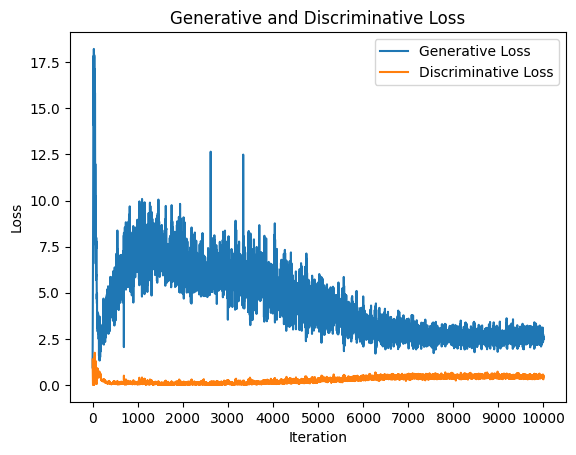

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss_curves(epochs, g_losses, d_losses, specific_iterations=None):

    g_losses = [loss.item() for loss in g_losses]
    d_losses = [loss.item() for loss in d_losses]

    plt.plot(epochs, g_losses, label='Generative Loss')
    plt.plot(epochs, d_losses, label='Discriminative Loss')

    plt.title('Generative and Discriminative Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    if specific_iterations:
        plt.xticks(specific_iterations)

    plt.legend(loc='best')
    plt.show()


epochs = range(1, len(G_losses) + 1)
step_size = len(G_losses) // 10
specific_iterations = list(range(0, len(G_losses) + 1, step_size))
if specific_iterations[-1] != len(G_losses):
    specific_iterations.append(len(G_losses))

plot_loss_curves(epochs, G_losses, D_losses, specific_iterations)

## **Visualization:**

By using the "img_list" you can visualize the animation of changes that occurred during training.

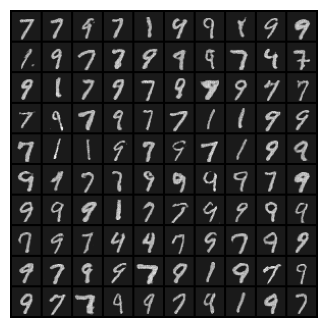

In [12]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(4, 4))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i.detach().cpu(), (1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# Generate samples

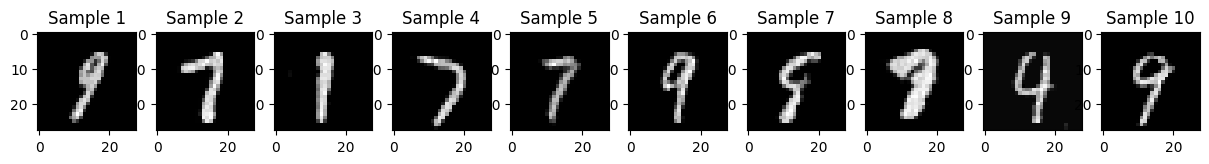

In [13]:
import matplotlib.pyplot as plt
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mymodel.to(device)

mymodel.eval()

num_samples = 10
img_gen_list = []

for i in range(num_samples):
    z = torch.randn(1, 64).to(device)
    x_fake = mymodel.g(z)
    img_gen_list.append(x_fake)

fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i in range(num_samples):
    x_fake_np = img_gen_list[i].squeeze().detach().cpu().numpy()
    axes[i].imshow(x_fake_np, cmap='gray')
    axes[i].set_title(f'Sample {i + 1}')

plt.show()


# FID

In [14]:
!pip install pytorch-ignite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.4/272.4 kB 5.1 MB/s eta 0:00:00


In [15]:
from ignite.metrics import FID
from ignite.engine import *
import PIL.Image as Image


fid_metric = FID(device=device)

batch_size = 128
z_dim = 64
sample_no = len(test_loader.dataset)

model_path = "/content/drive/MyDrive/MSC/Fall2023/DGM/HW2_part2/Q1_GAN/results/model_9900.pt"
netG = mymodel.g

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 124MB/s] 


In [16]:
z = torch.randn(sample_no,z_dim).to(device)
z_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(z), batch_size=batch_size)
noise_iter = iter(z_loader)

In [17]:
import PIL.Image as Image


def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))

        stacked_arr = torch.stack(arr)
        repeated_arr = stacked_arr.repeat(1, 3, 1, 1)
    return repeated_arr


def evaluation_step(engine, batch):
    with torch.no_grad():
        noise_batch = next(noise_iter)[0]
        netG.eval()
        fake_batch = netG(noise_batch)
        fake = interpolate(fake_batch)
        real = interpolate(batch[0])
        return fake, real

evaluator = Engine(evaluation_step)
fid_metric.attach(evaluator, "fid")


In [18]:
evaluator.run(test_loader,max_epochs=1)
metrics = evaluator.state.metrics
fid_score = metrics['fid']
print(f"*   FID : {fid_score:4f}")

*   FID : 0.077659


# WGAN
